In [1]:
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wisps.simulations as wispsim
import astropy.units as u
import splat.empirical as spe
import splat

Purpose: compare various luminosity functions

In [2]:
%matplotlib inline

In [3]:
baraffe=wispsim.simulate_spts(name="baraffe03")
saumon=wispsim.simulate_spts(name="saumon")

In [4]:
from astropy.io import ascii

In [5]:
klf=pd.read_csv('/users/caganze/research/wisps/data/kirkpatricklf.txt', delimiter=',')
dntb=ascii.read('/users/caganze/research/wisps/data/daniellalf.txt').to_pandas()

In [6]:
def splat_mag_to_spt(mag):
    grid=np.arange(17, 39)
    rel=spe.typeToMag(grid, 'MKO_J',reference='dupuy2012')[0]
    vals= np.polyval(rel, grid)
    spt_sorted_idx=np.argsort(vals)
    return np.interp(mag, vals[spt_sorted_idx], grid[spt_sorted_idx])
       

In [7]:
klf['tfm']=np.mean(np.array([klf.t0.values, klf.tf.values]), axis=0)

In [8]:
klf['spt']=klf.tfm.apply(wispsim.splat_teff_to_spt).apply(round)

In [9]:
klf=klf.applymap(float)

In [10]:
dntb['spt']=dntb.M_J.apply(splat_mag_to_spt)

In [11]:
dntb

,M_J,N,N_trig,N_phot,SFplx,SFphot,N_corrected,Density,spt
0,9.75,4,4,0,0.15,0.16,38.65,0.928,17.0
1,10.25,51,41,10,0.27,0.27,273.75,6.570,17.0
2,10.75,68,60,8,0.66,0.61,150.76,3.620,17.0
3,11.25,50,49,1,0.92,0.80,79.00,1.900,17.0
4,11.75,41,39,2,0.96,0.79,62.55,1.500,17.0
5,12.25,30,28,2,0.96,0.78,45.99,1.100,17.0
6,12.75,25,24,1,0.92,0.76,39.71,0.940,17.0
7,13.25,26,24,2,0.76,0.62,50.44,1.210,17.0
8,13.75,16,14,2,0.53,0.38,45.91,1.100,17.0


In [12]:
klf

,t0,tf,lf,lfunc,tfm,spt
0,1950.0,2100.0,0.57,0.20,2025.0,22.0
1,1800.0,1950.0,0.48,0.12,1875.0,23.0
2,1650.0,1800.0,0.63,0.09,1725.0,24.0
3,1500.0,1650.0,0.78,0.11,1575.0,25.0
4,1350.0,1500.0,0.00,0.00,1425.0,27.0
5,1200.0,1350.0,0.00,0.00,1275.0,33.0
6,1050.0,1200.0,0.00,0.00,1125.0,34.0
7,900.0,1050.0,1.12,0.00,975.0,36.0
8,750.0,900.0,1.68,0.23,825.0,38.0
9,600.0,750.0,3.55,0.51,675.0,38.0


In [13]:
def ryan_lf(J):
    logphi=-0.30 + 0.11*(J-14) + 0.15*(J -14)**2.+ 0.015*(J-14)**3-0.00020*(J-14)**4
    return (10**logphi)*(10**-3)

    
def custom_histogram(things, grid, binsize):
    n=[]
    for g in grid:
        n.append(len(things[np.logical_and(g<=things, things< g+binsize)]))
    return np.array(n)

In [14]:
from astropy.io import ascii

In [15]:
jgrid=np.arange(10, 18, .5)
teffgrid=np.arange(50, 4000, 150)

In [16]:
#add carnero rosell

In [17]:
teffs_bar=baraffe['teffs']
teffs_saumon=saumon['teffs']
normteff_bar = 0.63*(10**-3)/ len(teffs_bar[np.logical_and(teffs_bar>=1650, teffs_bar <=1800)])
normteff_saumon = 0.63*(10**-3)/ len(teffs_saumon[np.logical_and(teffs_saumon>=1650, teffs_saumon <=1800)])
#jmags=wisps.drop_nan(spe.typeToMag(SIMULATED_DIST['spts'][0], '2MASS J')[0])
#jnorm=6.570*(10**-3)/len(jmags[np.logical_and(jmags>=10.25-.25, jmags <=10.25+.25)])

In [18]:
#sem_emp_phi_j=custom_histogram(jmags, jgrid, .5)*jnorm
baraffe_phi_teff=custom_histogram(teffs_bar, teffgrid, 150)*normteff_bar
saumon_phi_teff=custom_histogram(teffs_saumon, teffgrid, 150)*normteff_saumon

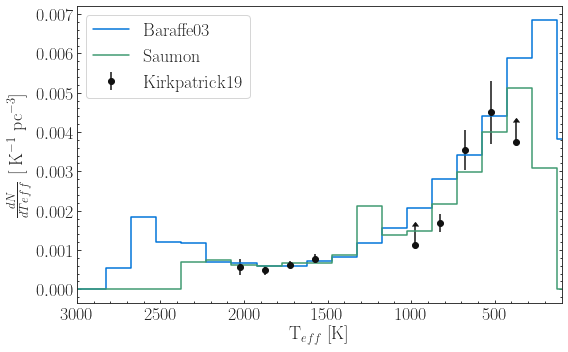

In [19]:
fig, ax1=plt.subplots(figsize=(8, 5), ncols=1)
#ax.step(jgrid, sem_emp_phi_j, color='#0074D9', label='Simulated')
#ax.step(jgrid,  ryan_lf(jgrid), color='#FF4136', label='RyanJr2017')
#ax.errorbar(dntb.M_J, dntb.Density*(10**-3), fmt='o', c='k', label='BG2019')

#ax.set_xlabel('J', fontsize=18)
#ax.set_ylabel(r'LF [pc$^{-3}$ mag$^{-1} $]', fontsize=18)
#ax.minorticks_on()
#ax.legend(fontsize=18)
#ax.set_xlim([10, 16])
#ax.set_ylim([0., 0.005])

ax1.step(teffgrid, baraffe_phi_teff, color='#0074D9', where='mid', label='Baraffe')
ax1.step(teffgrid, saumon_phi_teff, color='#3D9970', where='mid', label='Saumon')
for index, row in klf.iterrows():
    if row.lf==0.0:
        pass
    elif row.lfunc==0.0:
        ax1.errorbar(row.tfm,  row.lf*(10**-3), yerr=0.0005, color='#111111', fmt='o',lolims=True, ls='none')
    else:
        ax1.errorbar(row.tfm,  row.lf*(10**-3),  yerr=row.lfunc*(10**-3), color='#111111', fmt='o')
ax1.set_xlabel(r'T$_{eff}$ [K]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dTeff}$ [ K$^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=['Baraffe03', 'Saumon', 'Kirkpatrick19'])
ax1.set_xlim([3000, 100.])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_teffs.pdf')

In [20]:
js_saumon=spe.typeToMag(saumon['spts'].flatten(), '2MASS J')[0]
js_bar=spe.typeToMag(baraffe['spts'].flatten(), '2MASS J')[0]

In [21]:
jgrid=np.arange(10, 16, .5)

In [22]:
normjs_bar = 1.5*(10**-3)/ len(js_bar[np.logical_and(js_bar>=11.75, js_bar <11.75+0.5)])
normjs_saumon = 1.5*(10**-3)/ len(js_saumon[np.logical_and(js_saumon>=11.75,js_saumon<11.75+0.5)])

baraffe_phi_j=custom_histogram(js_bar, jgrid, 0.5)*normjs_bar
saumon_phi_j=custom_histogram(js_saumon, jgrid,0.5)*normjs_saumon

In [23]:
DNLF={"J": dntb.M_J.values, 'lf': dntb.Density.values, 
     "er":[[1.39, 0.39, 0.29, 0.20, 0.18, 0.15, 0.41, 0.16, 0.15], [1.62, 4.14, 0.31, 0.23, 0.20, 0.18, 1.65, 0.18, 0.18]]}

In [24]:
CRUZ={"J":[10.75, 11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75],
      "lf": [2.38, 1.66, 1.16, 0.83, 0.50, 0.58, 0.50, 0.66, 0.33],
     'er':[0.64, 0.37, 0.31, 0.26, 0.20, 0.22, 0.20, 0.23, 0.17]}

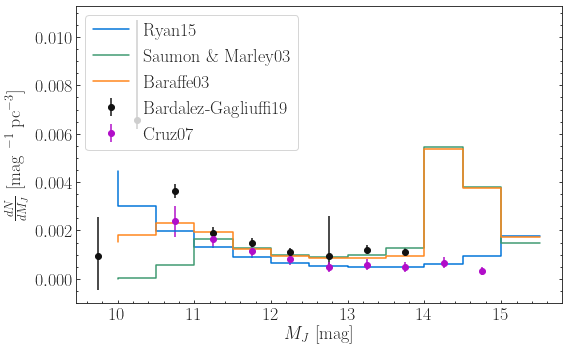

In [25]:
fig, ax1=plt.subplots(figsize=(8, 5), ncols=1)
plt.step(jgrid, ryan_lf(jgrid),  color='#0074D9')
plt.step(jgrid, saumon_phi_j,  color='#3D9970')
plt.step(jgrid, baraffe_phi_j,  color='#FF851B')
plt.errorbar(DNLF['J'], DNLF['lf']*0.001, yerr=np.array(DNLF['er'])*0.001,color='#111111', fmt='o')
plt.errorbar(CRUZ['J'], np.array(CRUZ['lf'])*0.001, yerr=np.array(CRUZ['er'])*0.001,color='#B10DC9', fmt='o')


ax1.set_xlabel(r'$M_J$ [mag]', fontsize=18)
ax1.set_ylabel(r'$\frac{dN}{dM_J}$ [mag $^{-1}$ pc$^{-3}$]', fontsize=18)
ax1.minorticks_on()
ax1.legend(fontsize=18, labels=['Ryan15', 'Saumon \& Marley03', 'Baraffe03', 'Bardalez-Gagliuffi19', 
                               'Cruz07'])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/lfs_js.pdf')

In [26]:
#save the inertpolated luminosity function
spt_grid=wisps.splat_teff_to_spt(teffgrid)
phi_spt=custom_histogram(baraffe['spts'], spt_grid, 1)*normteff_bar

In [27]:
LF={'spt':spt_grid, 'phi':phi_spt}

In [28]:
import pickle
with open(wisps.OUTPUT_FILES+'/lf.pkl', 'wb') as file:
   pickle.dump(LF,file)